# 💱 Problem 3 — Resource Trader (QUBO + QAOA / VQE)

Scopul este alegerea optimă a tranzacțiilor (trades) care maximizează profitul total și mențin echilibrul resurselor.
Fiecare variabilă binară $x_i$ indică dacă trade-ul $i$ este selectat.

Vom rula două metode cuantice:
- **QAOA** (Qiskit, Aer simulator)
- **VQE** (PennyLane)

Rezultatul: setul de tranzacții cu profit maxim fără dezechilibrarea resurselor.

In [1]:
# --- Imports ---
from pathlib import Path
import sys, os, numpy as np
import matplotlib.pyplot as plt

for r in [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]:
    if (r / 'src').exists():
        sys.path.append(str(r / 'src'))
        break

from catan.utils import set_seed, print_section, cprint, Colors
from problems.p3_resource_trader import build_trader_qubo
from catan.encodings.qiskit_qaoa import run_qaoa_qubo, plot_energy_landscape
from catan.encodings.pennylane_vqe import run_vqe_qubo, plot_vqe_convergence, plot_vqe_probabilities

In [2]:
# --- Parameters ---
N_TRADES = 8       # număr de tranzacții posibile
SEED = 42
METHOD = 'qaoa'    # 'qaoa' sau 'vqe'

set_seed(SEED)
print_section(f"Quantum Catan – P3 (Resource Trader)")
cprint(f"N_TRADES={N_TRADES}, METHOD={METHOD}", Colors.CYAN)


=== Quantum Catan – P3 (Resource Trader) ===
N_TRADES=8, METHOD=qaoa


In [3]:
# --- Build QUBO ---
Q, info = build_trader_qubo(n_trades=N_TRADES, trade_seed=SEED)
print_section("QUBO built")
print(f"Matrix shape: {Q.shape}")
cprint(f"Resources: {info['resources']}", Colors.YELLOW)


=== QUBO built ===
Matrix shape: (8, 8)
Resources: ['wood', 'brick', 'sheep', 'wheat', 'ore']


In [4]:
# --- Run Solver ---
if METHOD.lower() == 'qaoa':
    result = run_qaoa_qubo(Q, reps=1, optimizer='COBYLA', shots=256, seed=SEED)
    bitstring = result['best_bitstring']
    energy = result['best_energy']
    cprint(f"[QAOA] Done → best={bitstring}, energy={energy:.6f}", Colors.GREEN)
else:
    result = run_vqe_qubo(Q, layers=2, steps=100, lr=0.2, optimizer='adam')
    bitstring = result['best_bitstring']
    energy = result['best_energy']
    cprint(f"[VQE] Done → best={bitstring}, energy={energy:.6f}", Colors.GREEN)

[QAOA] Done in 1.54s | Best=10110011, Energy=-555.082479
[QAOA] Done → best=10110011, energy=-555.082479


In [5]:
# --- Decode solution and print trades ---
from problems.p3_resource_trader import print_trades_info
print_trades_info(info, bitstring)


=== Trade details ===
Trade 0: profit=3.91, Δr=[-3  2  1  0  0]
Trade 1: profit=2.10, Δr=[ 3 -3  1 -2 -3]
Trade 4: profit=4.00, Δr=[ 0 -1 -2  3  2]
Trade 5: profit=1.38, Δr=[ 1 -1  2  0  0]
Trade 7: profit=0.70, Δr=[-3  3  2 -2  1]

Total profit: 12.08
Net resource change: [-2  0  4 -1  0]


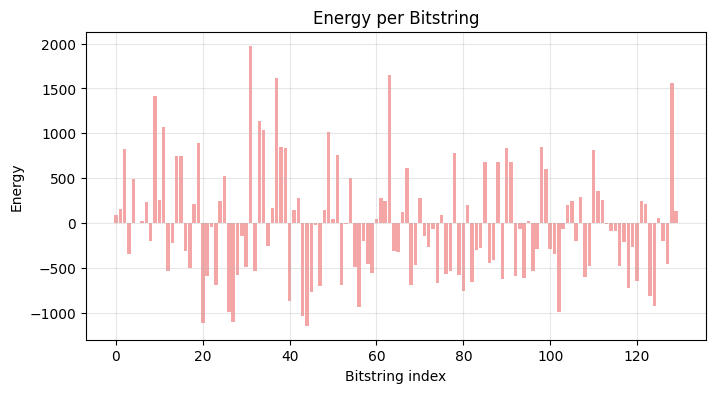

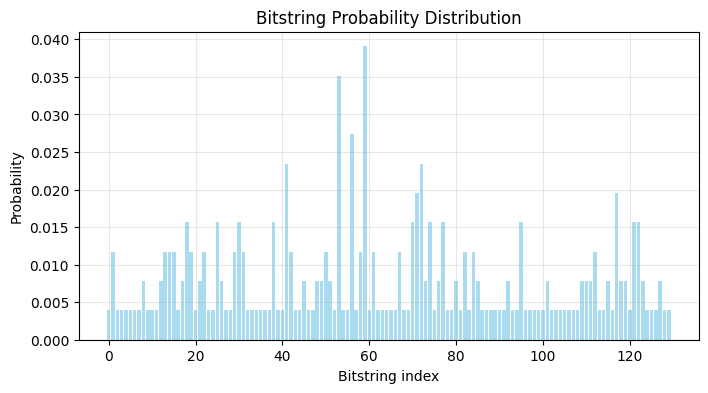

In [6]:
# --- Energy / Probability analysis ---
if METHOD.lower() == 'qaoa':
    plot_energy_landscape(result['bitstrings'], Q)
else:
    plot_vqe_convergence(result['energy_history'])
    plot_vqe_probabilities(result['probabilities'], Q)

In [7]:
# --- Save artefacts ---
out = Path('data'); out.mkdir(exist_ok=True)
np.save(out / 'p3_Q.npy', Q)
with open(out / 'p3_best.txt', 'w') as f:
    f.write(f'METHOD={METHOD}\nbitstring={bitstring}\nenergy={energy}\n')
cprint(f'Saved results to {out}/p3_Q.npy and p3_best.txt', Colors.GREEN)

Saved results to data/p3_Q.npy and p3_best.txt
